In [ ]:
import tensorflow as tf
import pandas as pd
import os
import re
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 00-パラメータ

In [ ]:
corpus = 200000
input_vocab_size = 5000
target_vocab_size = 5000
batch_size = 64
seq_len = 32
d_model = 512
num_heads = 8

DATA_PATH = "/content/drive/My Drive/MachineTranslate/data/split"
HOME_PATH = "/content/drive/My Drive/MachineTranslate/"

# 01-DataSet作成

## データ読込

In [ ]:
# https://nlp.stanford.edu/projects/jesc/index_ja.html
# !tar -xvf '/content/drive/My Drive/MachineTranslate/data/split.tar' -C '/content/drive/My Drive/MachineTranslate/data'

In [ ]:
with open(os.path.join(DATA_PATH + '/train'), 'r') as f:
  raw_data = f.readlines()

# データ内容
raw_data[:10]

["it's suliban.\tスリバン人です\n",
 'nothing thrills me more than to see kids pollinating plants instead of each other.\t生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!\n',
 'do you want to spend all night at the cemetery in this rain?\tこの雨の中 一晩中 墓地にいたい?\n',
 'our ships are in attack position.\t船はもう攻撃発起位置にある。\n',
 'what about the original sam? huh?\tオリジナルの サムが居るんだぞ\n',
 "even though, i don't like it, so quit your job!\tでも ヤダから お仕事 辞めて!\n",
 'goku continued on his journey alone, and became steadily stronger!\t悟空は 一人旅を続けて どんどん強くなった。\n',
 "we will now begin the emergency captains' meeting!\tこれより 緊急隊首会を行う。\n",
 'so in other words, because of the lights and the projectors\t言い換えれば 今ここにいる部屋の\n',
 'not funny, david. where the hell are you?\t一体どこに居るの?\n']

In [ ]:
# DataFrameで表示
raw_list = [re.sub('\n', '', s).split('\t') for s in raw_data]
raw_df = pd.DataFrame(raw_list, columns=['en', 'jp'])

raw_df.iloc[1]

en    nothing thrills me more than to see kids polli...
jp                      生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!
Name: 1, dtype: object

In [ ]:
print(raw_df.iloc[1]["en"])
print(raw_df.iloc[1]["jp"])

nothing thrills me more than to see kids pollinating plants instead of each other.
生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!


## DataSet作成

In [ ]:
corpus = 100000
jp_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    raw_df.iloc[:corpus]["jp"], target_vocab_size=input_vocab_size)

In [ ]:
en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    raw_df.iloc[:corpus]["en"], target_vocab_size=target_vocab_size)

In [ ]:
# サンプルの文章
sample_text_en = "nothing thrills me more than to see kids pollinating plants instead of each other."
sample_text_jp = "生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!"

text_en = en_tokenizer.encode(sample_text_en)
text_jp = jp_tokenizer.encode(sample_text_jp)
print(text_en)
print(text_jp)

print(en_tokenizer.decode(text_en))
print(jp_tokenizer.decode(text_jp))

[328, 2120, 1574, 3, 45, 116, 163, 6, 105, 1251, 4584, 860, 515, 1288, 3, 2698, 9, 362, 514, 4764]
[2755, 3962, 4481, 569, 1909, 2751, 2614, 4799, 2656, 3466, 1909, 4998, 4945, 4904, 6, 1263, 143, 1259, 185, 11, 4800]
nothing thrills me more than to see kids pollinating plants instead of each other.
生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!


In [ ]:
def encode_to_subword(en, jp):
  en_input = [en_tokenizer.vocab_size] + en_tokenizer.encode(en) + [en_tokenizer.vocab_size + 1]
  jp_input = [jp_tokenizer.vocab_size] + jp_tokenizer.encode(jp) + [jp_tokenizer.vocab_size + 1]

  return en_input, jp_input

In [ ]:
print(len(raw_df))

2797388


In [ ]:
raw_df_use = 100000

token_en, token_jp = [], []

for i in np.arange(raw_df_use):
  en, jp = encode_to_subword(raw_df.iloc[i]["en"], raw_df.iloc[i]["jp"])
  token_en.append(en)
  token_jp.append(jp)

In [ ]:
print(token_en[:5])
print(token_jp[:5])

[[4974, 14, 4757, 3, 558, 1841, 282, 4764, 4975], [4974, 328, 2120, 1574, 3, 45, 116, 163, 6, 105, 1251, 4584, 860, 515, 1288, 3, 2698, 9, 362, 514, 4764, 4975], [4974, 33, 4, 73, 6, 1894, 41, 781, 51, 2, 259, 1607, 98, 15, 18, 1127, 4781, 4975], [4974, 92, 908, 3, 24, 15, 1213, 1319, 4764, 4975], [4974, 20, 50, 2, 2988, 4750, 1063, 52, 251, 4781, 4975]]
[[5023, 58, 77, 1673, 2209, 35, 5024], [5023, 2755, 3962, 4481, 569, 1909, 2751, 2614, 4799, 2656, 3466, 1909, 4998, 4945, 4904, 6, 1263, 143, 1259, 185, 11, 4800, 5024], [5023, 21, 2742, 1134, 4799, 64, 1705, 143, 4799, 3759, 3683, 2037, 4830, 5024], [5023, 695, 3440, 55, 1027, 174, 1783, 3626, 1353, 2, 5024], [5023, 1841, 122, 2863, 67, 2090, 5, 2202, 45, 101, 5024]]


In [ ]:
token_en = tf.keras.preprocessing.sequence.pad_sequences(token_en, padding='post')
token_jp = tf.keras.preprocessing.sequence.pad_sequences(token_jp, padding='post')

dataset = tf.data.Dataset.from_tensor_slices((token_en, token_jp))
dataset = dataset.batch(batch_size)

In [ ]:
for i,j in dataset.take(3):
  print(i.shape, j.shape)

(16, 90) (16, 84)
(16, 90) (16, 84)
(16, 90) (16, 84)


In [ ]:
# レンズを取得
#EN_SEQ_LEN = i.shape[1]
#JP_SEQ_LEN = j.shape[1]
#print(EN_SEQ_LEN, JP_SEQ_LEN)

# 02-PositionalEncoding

In [ ]:
# 位置エンコーディング
def get_angle(pos, i, d_model):
  angle = 1 / (np.power(10000, (2 * (i // 2)) / d_model))
  return pos * angle

In [ ]:
def positional_encoding(position, d_model):
  # (position, 1) * (1 * d_model) = (position, d_model)
  pos =get_angle(np.arange(position)[:, np.newaxis],
                 np.arange(d_model)[np.newaxis, :],
                 d_model)

  pos[:, 0::2] = np.sin(pos[:, 0::2])
  pos[:, 1::2] = np.cos(pos[:, 1::2])

  # (1, position, d_model)
  pos = pos[np.newaxis, :]

  return pos

In [ ]:
emd_model = tf.keras.models.Sequential()
emd_model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model))
emd_model.compile('rmsprop', 'mse')

In [ ]:
input = np.random.randint(vocab_size, size=(batch_size, seq_len))
emd = emd_model.predict(input)
print(emd.shape)

1/1 [==============================] - 0s 46ms/step
(16, 32, 512)


In [ ]:
pos = positional_encoding(seq_len, d_model)
print(pos.shape)

(1, 32, 512)


In [ ]:
# broadcastして加算
x = emd + pos

print(x.shape)

(16, 32, 512)


# 03-MultiHeadAttention

## Masking

In [ ]:
# padマスク、0の値は利用しない
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), dtype=tf.float32)
  # shape:(batch_size, 1, 1, seq_len)
  return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
create_padding_mask([[1,1,0,2,0,1], [1,1,0,2,0,1],[1,2,3,0,0,0]])

<tf.Tensor: shape=(3, 1, 1, 6), dtype=float32, numpy=
array([[[[0., 0., 1., 0., 1., 0.]]],


       [[[0., 0., 1., 0., 1., 0.]]],


       [[[0., 0., 0., 1., 1., 1.]]]], dtype=float32)>

In [ ]:
# decordlayer用、未来の値を利用しない
# num_lower: <0 対角線下の数値を保留
# num_upper: <0 対角線上の数値を保留
def create_look_ahead_attention(size):
  # shape:(seq_len, seq_len)
  return 1 - tf.linalg.band_part(tf.ones(size), -1, 0)

In [ ]:
create_look_ahead_attention(size=(3,3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled_dot_product_attention

In [ ]:
# スケーリングドットアテンション
# q.shape : (..., seq_len_q, depth)
# k.shape : (..., seq_len_k, depth)
# v.shape : (..., seq_len_v, depth)
# seq_len_k = seq_len_v
def scaled_dot_product_attention(q, k, v, mask):

  # matmul_qk.shape : (..., seq_len_q, seq_len_k)
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)

  attention_logics = matmul_qk / (tf.math.sqrt(dk))

  if mask is not None:
    # マスクした値には、attention_weight計算しない
    # softmax後、該当セルは０
    attention_logics = attention_logics + (mask * -1e9)

  # attention_weight.shape : (..., seq_len_q, seq_len_k)
  attention_weight = tf.nn.softmax(attention_logics, axis=-1)

  # output.shape : (..., seq_len_q, depth_v)
  output = tf.matmul(attention_weight, v)

  return output, attention_weight

In [ ]:
q ,k ,v = tf.random.uniform((3, 3)), tf.random.uniform((3, 3)), tf.random.uniform((3, 3))
q

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.12011957, 0.7831305 , 0.7119875 ],
       [0.953565  , 0.7377409 , 0.33274424],
       [0.8485472 , 0.60162365, 0.09473789]], dtype=float32)>

In [ ]:
scaled_dot_product_attention(q, k, v, None)

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.40309814, 0.1800717 , 0.49979427],
        [0.4208225 , 0.19373214, 0.5174483 ],
        [0.42298996, 0.1935741 , 0.51491153]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.41097155, 0.28129098, 0.3077375 ],
        [0.43433118, 0.3149782 , 0.25069067],
        [0.41058686, 0.32722145, 0.26219174]], dtype=float32)>)

In [ ]:
mask_look_ahead= create_look_ahead_attention(size=(3,3))
mask_pad = create_padding_mask(q)

In [ ]:
scaled_dot_product_attention(q, k, v, mask_look_ahead)

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.35906804, 0.19061553, 0.57015884],
        [0.48584628, 0.2479448 , 0.5927371 ],
        [0.42298996, 0.1935741 , 0.51491153]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1.        , 0.        , 0.        ],
        [0.579642  , 0.42035803, 0.        ],
        [0.41058686, 0.32722145, 0.26219174]], dtype=float32)>)

In [ ]:
scaled_dot_product_attention(q, k, v, mask_pad)

(<tf.Tensor: shape=(3, 1, 3, 3), dtype=float32, numpy=
 array([[[[0.40309814, 0.1800717 , 0.49979427],
          [0.4208225 , 0.19373214, 0.5174483 ],
          [0.42298996, 0.1935741 , 0.51491153]]],
 
 
        [[[0.40309814, 0.1800717 , 0.49979427],
          [0.4208225 , 0.19373214, 0.5174483 ],
          [0.42298996, 0.1935741 , 0.51491153]]],
 
 
        [[[0.40309814, 0.1800717 , 0.49979427],
          [0.4208225 , 0.19373214, 0.5174483 ],
          [0.42298996, 0.1935741 , 0.51491153]]]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1, 3, 3), dtype=float32, numpy=
 array([[[[0.41097155, 0.28129098, 0.3077375 ],
          [0.43433118, 0.3149782 , 0.25069067],
          [0.41058686, 0.32722145, 0.26219174]]],
 
 
        [[[0.41097155, 0.28129098, 0.3077375 ],
          [0.43433118, 0.3149782 , 0.25069067],
          [0.41058686, 0.32722145, 0.26219174]]],
 
 
        [[[0.41097155, 0.28129098, 0.3077375 ],
          [0.43433118, 0.3149782 , 0.25069067],
          [0.41058686, 0.32722

## Multi-Head Attention

In [ ]:
# マルチヘッドアテンション
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads

    # evenly divisible、均等に割り切れる
    assert self.d_model % self.num_heads == 0

    self.depth = tf.cast(d_model / self.num_heads, tf.int64)

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  # マルチヘッダ、d_model⇨(num_heads, depth)
  def split_heads(self, x, batch_size):
    # x.shape.     : (batch_size, seq_len, d_model)
    # →→ reshape.  : (batch_size, seq_len, num_heads, depth)
    # →→ transpose : (batch_size, num_heads, seq_len, depth)
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):

    batch_size = tf.cast(tf.shape(q)[0], tf.int64)

    # q.shape : (batch_size, seq_len_q, d_model)
    # k.shape : (batch_size, seq_len_k, d_model)
    # v.shape : (batch_size, seq_len_v, d_model)
    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    # q.shape : (batch_size, num_heads, seq_len_q, depth)
    # k.shape : (batch_size, num_heads, seq_len_k, depth)
    # v.shape : (batch_size, num_heads, seq_len_v, depth)
    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    # attention_weight.shape : (batch_size, num_heads, seq_len_q, seq_len_k)
    # output.shape           : (batch_size, num_heads, seq_len_q, depth)
    scaled_attention, attention_weight = scaled_dot_product_attention(q, k, v, mask)

    # output.shape           : (batch_size, seq_len_q, num_heads, depth)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # output.shape           : (batch_size, seq_len_q, d_model)
    scaled_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(scaled_attention)

    return output, attention_weight

In [ ]:
temp_mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
y = tf.random.uniform((batch_size, seq_len, d_model))  # (batch_size, seq_len, d_model)
out, attn = temp_mha(y, y, y, mask=None)
print(out.shape, attn.shape)

(16, 32, 512) (16, 8, 32, 32)


# 04-FeedForward

In [ ]:
def point_wise_feed_forward_netword(d_model, diff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(units=diff, activation="relu"),
      tf.keras.layers.Dense(units=d_model)
      ])

In [ ]:
fee = tf.random.uniform((batch_size, seq_len, d_model))
fee.shape

TensorShape([16, 32, 512])

In [ ]:
seq_feed = point_wise_feed_forward_netword(d_model, 2048)
seq_feed(fee).shape

TensorShape([16, 32, 512])

# 05-EncoderLayer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff):
    super(EncoderLayer, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff

    # Muti-Head Attention
    self.mha = MultiHeadAttention(self.d_model, self.num_heads)

    # Feed Forward Network
    self.ffn = point_wise_feed_forward_netword(self.d_model, self.dff)

    # LayerNormalization
    self.layNorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layNorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate=0.1)
    self.dropout2 = tf.keras.layers.Dropout(rate=0.1)

  def call(self, x, enc_padding_mask):
    # lay1: Muti-Head Attention
    out1, _ = self.mha(x, x, x, mask=enc_padding_mask)
    out1 = self.dropout1(out1)
    #print("out1:", out1.shape)

    # lay2: Add & Norm
    x = self.layNorm1(x + out1)
    x = self.dropout2(x)

    # Lay3: Feed Fordward
    out2 = self.ffn(x)
    #print("out2:", out2.shape)

    # lay4: Add & Norm
    x = self.layNorm2(x + out2)

    # (batch_size, seq_len, d_model)
    return x

In [ ]:
encoder = EncoderLayer(d_model, num_heads, dff=2048)

x = tf.random.uniform((batch_size, seq_len, d_model))

encoder(x, enc_padding_mask=None).shape

TensorShape([16, 32, 512])

# 06-EncoderModel

In [ ]:
class EncoderModel(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model, max_postition_len,
               num_layers, num_heads, dff):
    super(EncoderModel, self).__init__()

    self.d_model = d_model
    self.max_postition_len = max_postition_len
    self.num_layers = num_layers

    self.emd = tf.keras.layers.Embedding(vocab_size, d_model)

    self.pos = positional_encoding(max_postition_len, d_model)

    self.encoder = [EncoderLayer(d_model, num_heads, dff) for _ in range(num_layers)]

  def call(self, x, mask):
    # 初期
    # x.shape: (batch_size, sq_len)
    seq_len = tf.shape(x)[1]
    #print("seq_len:", seq_len)

    # lay1: 埋め込み
    # x.shape: (batch_size, sq_len, d_model)
    x = self.emd(x)
    #print("x1:", x.shape)

    x = x * tf.math.sqrt(tf.cast(self.d_model, dtype=tf.float32))
    #print("x2:", x.shape)

    # lay2: 位置エンコーディング
    # x.shape: (batch_size, sq_len, d_model)
    positional = self.pos[:, :seq_len, :]
    #print("positional:", positional.shape)
    x = x + positional
    #print("x3:", x.shape)

    # lay3: エンコーディング
    # x.shape: (batch_size, sq_len, d_model)
    for i in range(self.num_layers):
      x = self.encoder[i](x, mask)

    return x

In [ ]:
encoderModel = EncoderModel(input_vocab_size, d_model, seq_len, 6, num_heads, 2048)
x = tf.random.uniform((batch_size, seq_len))

In [ ]:
encoder_out = encoderModel(x, mask=None)
encoder_out.shape

TensorShape([16, 32, 512])

# 07-DecoderLayer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff):
    super(DecoderLayer, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff

    # Muti-Head Attention
    self.mha1 = MultiHeadAttention(self.d_model, self.num_heads)
    self.mha2 = MultiHeadAttention(self.d_model, self.num_heads)

    # Feed Forward Network
    self.ffn = point_wise_feed_forward_netword(self.d_model, self.dff)

    # LayerNormalization
    self.layNorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layNorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layNorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate=0.1)
    self.dropout2 = tf.keras.layers.Dropout(rate=0.1)
    self.dropout3 = tf.keras.layers.Dropout(rate=0.1)

  def call(self, x, encoding_input, combined_mask, enc_dec_padding_mask):
    # lay1: Masked Muti-Head Attention
    mha_out1, attention_weight1 = self.mha1(x, x, x, mask=combined_mask)
    mha_out1 = self.dropout1(mha_out1)
    #print("mha_out1:", mha_out1.shape)

    # lay2: Add & Norm
    layNorm_out1 = self.layNorm1(x + mha_out1)

    # lay3: Muti-Head Attention
    # v,k:encoding_input
    # q  :layNorm_out1
    mha_out2, attention_weight2 = self.mha2(
        encoding_input, encoding_input, layNorm_out1,  mask=enc_dec_padding_mask)
    #print("mha_out2:", mha_out2.shape)
    mha_out2 = self.dropout2(mha_out2)

    # lay4: Add & Norm
    layNorm_out2 = self.layNorm1(layNorm_out1 + mha_out2)

    # Lay5: Feed Fordward
    ffn_out = self.ffn(layNorm_out2)
    #print("ffn_out:", ffn_out.shape)
    ffn_out = self.dropout3(ffn_out)

    # lay6: Add & Norm
    layNorm_out3 = self.layNorm3(layNorm_out2 + ffn_out)

    return layNorm_out3

In [ ]:
decoder = DecoderLayer(d_model, num_heads, dff=2048)

x = tf.random.uniform((batch_size, seq_len, d_model))

decoder(x, encoder_out, None, None).shape

TensorShape([16, 32, 512])

# 08-DecoderModel

In [ ]:
class DecoderModel(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model, max_postition_len,
               num_layers, num_heads, dff):
    super(DecoderModel, self).__init__()

    self.d_model = d_model
    self.max_postition_len = max_postition_len
    self.num_layers = num_layers

    self.emd = tf.keras.layers.Embedding(vocab_size, d_model)

    self.pos = positional_encoding(max_postition_len, d_model)

    self.decoder = [DecoderLayer(d_model, num_heads, dff) for _ in range(num_layers)]

  def call(self, x, encoder_out, combined_mask, enc_dec_padding_mask):
    # 初期
    # x.shape: (batch_size, sq_len)
    seq_len = tf.shape(x)[1]
    #print("seq_len:",seq_len)

    # lay1: 埋め込み
    # x.shape: (batch_size, sq_len, d_model)
    x = self.emd(x)
    #print("x1:", x.shape)

    x = x * tf.math.sqrt(tf.cast(self.d_model, dtype=tf.float32))

    # lay2: 位置エンコーディング
    # x.shape: (batch_size, sq_len, d_model)
    positional = self.pos[:, :seq_len, :]
    #print("positional:",positional.shape)
    x = x + positional
    #print("x2:", x.shape)

    # lay3: エンコーディング
    # x.shape: (batch_size, sq_len, d_model)
    for i in range(self.num_layers):
      x = self.decoder[i](x, encoder_out, combined_mask, enc_dec_padding_mask)

    # (batch_size, tar_seq_len, d_model)
    return x

In [ ]:
decoderModel = DecoderModel(target_vocab_size, d_model, seq_len, 6, num_heads, 2048)
x = tf.random.uniform((batch_size, seq_len))

In [ ]:
out = decoderModel(x, encoder_out, combined_mask=None, enc_dec_padding_mask=None)
out.shape

TensorShape([16, 32, 512])

# 09-Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, input_vocab_size, target_vocab_size, input_seq_len,
             target_seq_len, d_model, num_heads, num_layers, dff):

    super().__init__()

    # Encoding
    self.encoder_model = EncoderModel(input_vocab_size, d_model, input_seq_len,
                                      num_layers, num_heads, dff)

    # Decoding
    self.decoder_model = DecoderModel(target_vocab_size, d_model, target_seq_len,
                                      num_layers, num_heads, dff)

    # 全結合層
    self.linear = tf.keras.layers.Dense(target_vocab_size)

  def call(self, input_target):
    # pairとして入力
    x_input, y_target = input_target
    #print("x_input:", x_input)
    #print("y_target:", y_target)

    # マスク
    enc_padding_mask, combined_mask, enc_dec_padding_mask = self.create_mask(x_input, y_target)

    # encode.shape:(batch_size, seq_len, d_model)
    encoder_output = self.encoder_model(x_input, mask=enc_padding_mask)

    # decode.shape:(batch_size, seq_len, d_model)
    decoder_output = self.decoder_model(y_target, encoder_output,
                                        combined_mask=combined_mask,
                                        enc_dec_padding_mask=enc_dec_padding_mask)

    # (batch_size, seq_len, vocab_size)
    output = self.linear(decoder_output)

    #output = tf.nn.softmax(output)
    #print("tansformer out:", output.shape)

    return output

  def create_mask(self, inp, tar):
    #print("###create_mask")

    # マスク１：エンコーディングのMulti-Head Attention用
    enc_padding_mask = create_padding_mask(inp)
    #print("enc_padding_mask:", enc_padding_mask.shape)

    # マスク２：デンコーディングのMulti-Head Attention用
    # エンコーディングのINPUT
    enc_dec_padding_mask = create_padding_mask(inp)
    #print("enc_dec_padding_mask:", enc_dec_padding_mask.shape)

    # マクス３：デンコーディングのLAY1用
    size = (tar.shape[1], tar.shape[1])
    look_ahead_mask = create_look_ahead_attention(size)
    #print("look_ahead_mask:", look_ahead_mask.shape)
    dec_padding_mask = create_padding_mask(tar)
    #print("dec_padding_mask:", dec_padding_mask.shape)

    combined_mask = tf.maximum(look_ahead_mask, dec_padding_mask)

    return enc_padding_mask, combined_mask, enc_dec_padding_mask

In [ ]:
temp_transformer = Transformer(8500, 8000, 1000, 1000, 512, 8, 6, 2048)

In [ ]:
x_input = tf.random.uniform((batch_size, 100))
y_target = tf.random.uniform((batch_size, 101))

out = temp_transformer([x_input, y_target])

# 10-LossFunction

In [ ]:
# from_logits=True , 原始データ、softmax層で処理されない。
# from_logits=False, 処理されたデータ
# reduction=sum, lossをsum。　reduction=none, そのまま返す
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")

def loss_function(real, pred):

  # real=0, Falseにする
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  #print("mask:",mask.shape)
  loss_ = loss_object(real, pred)
  #print("loss_:",loss_.shape)

  # False:0, mask:[1, 1, 0, 0]
  mask = tf.cast(mask, dtype=loss_.dtype)

  # 0の場合、loss計算しない
  loss_ *= mask

  # 平均を求める
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean("train_loss")

In [ ]:
real = [1, 1, 0]
pred = [[0.05, 0.95],[0.05, 0.95],[0.05, 0.95]]

loss_function(real, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.34115392>

# 11-Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

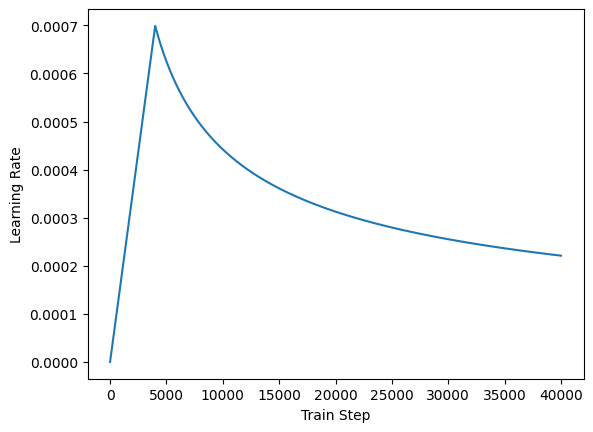

In [ ]:
from matplotlib import pyplot as plt
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(128)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
transformer = Transformer(input_vocab_size=input_vocab_size,
                          target_vocab_size=target_vocab_size,
                          input_seq_len=100,
                          target_seq_len=100,
                          d_model=128,
                          num_heads=4,
                          num_layers=4,
                          dff=512)

In [ ]:
inp = tf.random.uniform((batch_size, seq_len))
#print("inp:", inp.dtype)
tar = tf.random.uniform((batch_size, seq_len))
#print("tar:", tar.dtype)
enc_padding_mask, combined_mask, enc_dec_padding_mask = create_mask(inp, tar)
print("enc_padding_mask:", enc_padding_mask.shape)
print("combined_mask:", combined_mask.shape)
print("enc_dec_padding_mask:", enc_dec_padding_mask.shape)

enc_padding_mask: (16, 1, 1, 32)
combined_mask: (16, 1, 32, 32)
enc_dec_padding_mask: (16, 1, 1, 32)


# 12-CheckPoint

In [ ]:
chk_path = HOME_PATH + 'checkpoint/train'

checkpoint = tf.train.Checkpoint(ptimizer=optimizer, transformer=transformer)

chk_manager = tf.train.CheckpointManager(checkpoint,
                                         directory=chk_path, max_to_keep=5)

if chk_manager.latest_checkpoint:
  checkpoint.restore(chk_manager.latest_checkpoint)

# 13-Training

In [ ]:
def train_step(inp, tar):
  # exp  : A B C D ⇨ E F G H
  # 並行処理
  # train: A B C D、E F G ⇨ F G H

  #print("------inp::",inp)
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  #print("tar_real:",tar_real.shape)

  with tf.GradientTape() as tape:

    #print("inp::",inp)

    predict = transformer([inp, tar_inp])

    #print("predict:", predict.shape)
    loss = loss_function(tar_real, predict)
    #print("loss:", loss.shape)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)

In [ ]:
Epoches = 3

for i in range(Epoches):
  print(f"#####epoches:{i}######")
  train_loss.reset_states()

  for (batch, (en ,jp)) in enumerate(dataset):
    #print("en:", en)
    #print("jp:", jp)
    train_step(en, jp)

    if (batch % 100 == 0):
      print(f"epoches:{i},batch_size:{batch},loss:{train_loss.result()}")

#####epoches:0######
epoches:0,batch_size:0,loss:nan
epoches:0,batch_size:100,loss:nan
epoches:0,batch_size:200,loss:nan
epoches:0,batch_size:300,loss:nan
epoches:0,batch_size:400,loss:nan
epoches:0,batch_size:500,loss:nan
epoches:0,batch_size:600,loss:nan
epoches:0,batch_size:700,loss:nan
epoches:0,batch_size:800,loss:nan
epoches:0,batch_size:900,loss:nan
epoches:0,batch_size:1000,loss:nan
epoches:0,batch_size:1100,loss:nan
epoches:0,batch_size:1200,loss:nan
epoches:0,batch_size:1300,loss:nan
epoches:0,batch_size:1400,loss:nan
epoches:0,batch_size:1500,loss:nan
epoches:0,batch_size:1600,loss:nan
epoches:0,batch_size:1700,loss:nan
epoches:0,batch_size:1800,loss:nan
epoches:0,batch_size:1900,loss:nan
epoches:0,batch_size:2000,loss:nan
epoches:0,batch_size:2100,loss:nan
epoches:0,batch_size:2200,loss:nan
epoches:0,batch_size:2300,loss:nan


KeyboardInterrupt: ignored

# 14-Translate

In [ ]:
# eva: A B C D → E
#      A B C D, E → E F
# eva: A B C D, E F → E F G
# eva: A B C D, E F G → E F G H
# eva: A B C D, E F G H → E F G H </s>
def translate(sentence):

  enc_input = [en_tokenizer.vocab_size] + en_tokenizer.encode(sentence) + [en_tokenizer.vocab_size + 1]
  print("enc_input:", enc_input)

  # shape:(1, seq_len)
  enc_input = tf.expand_dims(enc_input, 0)

  # shape:(1, 1)
  dec_input = tf.constant([[jp_tokenizer.vocab_size]])

  for i in tf.range(10):
    # shape:(1, seq_len, vocab_size)
    predictions = transformer([enc_input, dec_input])
    #print("predictions:", predictions)

    # shape:(1, vocab_size)
    predictions = predictions[:, -1, :]
    #print("predictions:", predictions)

    # shape:(1,)
    predicted_id = tf.expand_dims(tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32), 0)
    #print("predicted_id:", predicted_id)

    # shape:(1, ...)
    dec_input = tf.concat([dec_input, predicted_id], axis=-1)
    #print("dec_input:", dec_input)

    if predicted_id == [2]:
      return jp_tokenizer.decode(dec_input[0][1:])
        #return dec_input

  return jp_tokenizer.decode(dec_input[0][1:])

In [ ]:
translate("it is very cold")

In [ ]:
translate("our ships1123")

In [ ]:
jp_tokenizer.encode('-襲')

In [ ]:
class Translator(tf.Module):
  def __init__(self, token_en, token_jp, transformer):
    self.tokenizers_en = token_en
    self.tokenizers_jp = token_jp
    self.transformer = transformer

  def __call__(self, sentence, max_length=10):

    sentence = tf.convert_to_tensor(self.tokenizers_en.encode(sentence))

    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    encoder_input = sentence

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, [1])

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())

      print("output:", output)

      predictions = self.transformer([encoder_input, output])

      # select the last token from the seq_len dimension
      #predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      print("predictions2:", predictions.shape)

      predicted_id = tf.argmax(predictions, axis=-1)

      print("predicted_id3:", predicted_id)

      #predicted_word = tf.compat.as_text(self.tokenizers_jp.Decode(predicted_id[0]))

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      print("output_array:::",output_array)

      if predicted_id == [2]:
        break

    output = tf.transpose(output_array.stack())
    print("output:", output)
    # output.shape (1, tokens)
    text = self.tokenizers_jp.Decode(output)[0]  # shape: ()

    #tokens = self.tokenizers_jp.lookup(output)[0]

    #"_, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text #, tokens, attention_weights

In [ ]:
translator = Translator(en_tokenizer, jp_tokenizer, transformer)

sentence = ["you are very good"]
print(en_tokenizer.encode(sentence))

translated_text = translator(sentence)